# Models Predicting Accident Severity

 * [Imports and Model Specific Cleaning](#IMSC)
 * [Models](#mods)
 * [RandomForest](#rf)
 * [LogisticRegression](#logr)
 * [DecisionTree](#dt)
 * [Model Results](#mr)

<a id='IMSC'></a>
## Imports and Model Specific Cleaning

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# set view columns to 250
pd.set_option('display.max_columns',250)

In [3]:
# read in data
accidents = pd.read_csv('../project-5/data/severity_model_data/selected.csv',index_col = 0)

In [4]:
# create balanced classes (severity 1 is the smallest with 29312 instances)
sev_1 = accidents[accidents['severity'] == 1]
sev_2 = accidents[accidents['severity'] == 2].head(29312)
sev_3 = accidents[accidents['severity'] == 3].head(29312)
sev_4 = accidents[accidents['severity'] == 4].head(29312)
selected = pd.concat([sev_1,sev_2,sev_3,sev_4], axis = 0).reset_index()

In [5]:
# print only columns with nulls and their null values
for col in selected.columns:
    if selected[col].isnull().sum() > 0:
        print(col)
        print(selected[col].isnull().sum())

temperaturef
1810
humidity
2086
visibilitymi
2084
wind_speedmph
16969
precipitationin
76191
weather_condition
2172
wind_chillf
73105


In [6]:
# map side
selected['side'] = selected['side'].map({'R':1,'L':0})

In [7]:
# fill NaN values for side column
selected['side'] = selected['side'].fillna(1)

In [8]:
# fill NaN values for precipitationin column
selected['precipitationin'] = selected['precipitationin'].fillna(0)

In [9]:
# fill NaN values for temperaturef column
selected['temperaturef'].fillna(selected['temperaturef'].median(), inplace=True)

In [10]:
# fill NaN values for humidity column
selected['humidity'].fillna(100.0, inplace=True)

In [11]:
# fill NaN values for visibilitymi column
selected['visibilitymi'].fillna(selected['visibilitymi'].median(), inplace=True)

In [12]:
# fill NaN values for weather_condition column
selected['weather_condition'].fillna('Fair', inplace=True)

In [13]:
# caluculate wind_chillf column for nan values if temp and wind chill are provided
selected['wind_chillf'] = selected.apply(lambda row: row[
    'temperaturef'] - row['wind_speedmph'] if np.isnan(row['wind_chillf']) else row['wind_chillf'], axis=1)

In [14]:
# fill NaN values for wind_speedmph column
selected['wind_speedmph'].fillna(0, inplace=True)

In [15]:
# fill NaN values for wind_chillf column
selected['wind_chillf'].fillna(selected['temperaturef'], inplace=True)

In [16]:
# dummify columns
selected = pd.get_dummies(selected,columns = ['start_hour','month','end_hour','county','weather_condition'])

In [17]:
# drop index columns
selected.drop(columns = ['index','county.1'],inplace = True)

In [18]:
selected.head()

,severity,temperaturef,humidity,visibilitymi,wind_speedmph,precipitationin,traffic_signal,side,crossing,junction,stop,distancemi,wind_chillf,traffic_signal.1,sunrise_sunset,civil_twilight,nautical_twilight,astronomical_twilight,total_duration,start_hour_0,start_hour_1,start_hour_2,start_hour_3,start_hour_4,start_hour_5,start_hour_6,start_hour_7,start_hour_8,start_hour_9,start_hour_10,start_hour_11,start_hour_12,start_hour_13,start_hour_14,start_hour_15,start_hour_16,start_hour_17,start_hour_18,start_hour_19,start_hour_20,start_hour_21,start_hour_22,start_hour_23,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,end_hour_0,end_hour_1,end_hour_2,end_hour_3,end_hour_4,end_hour_5,end_hour_6,end_hour_7,end_hour_8,end_hour_9,end_hour_10,end_hour_11,end_hour_12,end_hour_13,end_hour_14,end_hour_15,end_hour_16,end_hour_17,end_hour_18,end_hour_19,end_hour_20,end_hour_21,end_hour_22,end_hour_23,county_AcadiaLA,county_AccomackVA,county_AdaID,county_AdairIA,county_AdamsCO,county_AdamsIA,county_AdamsID,county_AdamsIN,county_AdamsNE,county_AdamsOH,county_AdamsPA,county_AdamsWA,county_AdamsWI,county_AddisonVT,county_AikenSC,county_AlachuaFL,county_AlamanceNC,county_AlamedaCA,county_AlamosaCO,county_AlbanyNY,county_AlbanyWY,county_AlbemarleVA,county_AlconaMI,county_AlexanderNC,county_AlexandriaVA,county_AllamakeeIA,county_AlleganMI,county_AlleganyMD,county_AlleganyNY,county_AlleghanyVA,county_AlleghenyPA,county_AllenIN,county_AllenOH,county_AlpenaMI,county_AlpineCA,county_AmadorCA,county_AmeliaVA,county_AmherstVA,county_AndersonKY,county_AndersonSC,county_AndersonTN,county_AndrewMO,county_AndroscogginME,county_Anne ArundelMD,county_AnokaMN,county_AnsonNC,...,county_WillIL,county_WilliamsOH,county_WilliamsonIL,county_WilliamsonTN,county_WilliamsonTX,county_WilsonNC,county_WilsonTN,county_WindhamCT,county_WindhamVT,county_WindsorVT,county_WinnebagoIA,county_WinnebagoIL,county_WinnebagoWI,county_WinneshiekIA,county_WinonaMN,county_WiseVA,county_WolfeKY,county_WoodOH,county_WoodWI,county_WoodWV,county_WoodburyIA,county_WoodfordKY,county_WorcesterMA,county_WorcesterMD,county_WorthGA,county_WorthIA,county_WrightIA,county_WrightMN,county_WrightMO,county_WyandotOH,county_WyandotteKS,county_WyomingNY,county_WyomingPA,county_WytheVA,county_YadkinNC,county_YakimaWA,county_YalobushaMS,county_YamhillOR,county_YatesNY,county_YavapaiAZ,county_YellowstoneMT,county_YoakumTX,county_YoloCA,county_YorkME,county_YorkNE,county_YorkPA,county_YorkSC,county_YorkVA,county_YubaCA,county_YumaAZ,county_YumaCO,weather_condition_Blowing Dust,weather_condition_Blowing Dust / Windy,weather_condition_Blowing Sand,weather_condition_Blowing Snow,weather_condition_Clear,weather_condition_Cloudy,weather_condition_Cloudy / Windy,weather_condition_Drizzle,weather_condition_Fair,weather_condition_Fair / Windy,weather_condition_Fog,weather_condition_Fog / Windy,weather_condition_Freezing Rain / Windy,weather_condition_Hail,weather_condition_Haze,weather_condition_Haze / Windy,weather_condition_Heavy Drizzle,weather_condition_Heavy Rain,weather_condition_Heavy Rain / Windy,weather_condition_Heavy Snow,weather_condition_Heavy Snow / Windy,weather_condition_Heavy T-Storm,weather_condition_Heavy T-Storm / Windy,weather_condition_Heavy Thunderstorms and Rain,weather_condition_Heavy Thunderstorms and Snow,weather_condition_Light Drizzle,weather_condition_Light Drizzle / Windy,weather_condition_Light Freezing Drizzle,weather_condition_Light Freezing Fog,weather_condition_Light Freezing Rain,weather_condition_Light Haze,weather_condition_Light Ice Pellets,weather_condition_Light Rain,weather_condition_Light Rain / Windy,weather_condition_Light Rain Shower,weather_condition_Light Rain Shower / Windy,weather_condition_Light Rain Showers,weather_condition_Light Rain with Thunder,weather_condition_Light Sleet,weather_condition_Light Snow,weather_condition_Light Snow / Windy,weather_condition_Light Snow Showers,weather_condition_Light Thunderstorms 

<a id='mods'></a>
## Models

In [19]:
# create a features variable
features = [col for col in selected.columns if col not in ['severity']]

In [20]:
# set X and y variables
X = selected[features]
y = selected['severity']

In [21]:
# train_test_split data
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42)

In [22]:
# scale data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

<a id='rf'></a>
### RandomForest

In [23]:
# instantiate RandomForestClassifier
rf = RandomForestClassifier()

In [24]:
# fit model
rf.fit(X_train_sc,y_train)

RandomForestClassifier()

In [25]:
# score train data
rf.score(X_train_sc,y_train)

0.9966339155749636

In [26]:
# score test data
rf.score(X_test_sc,y_test)

0.8764669759825328

In [27]:
# pickle best model
#pickle.dump(rf,open('randomforest_gmodel.p', 'wb'))

In [28]:
# create a dataframe of important features
i_features_rf = pd.DataFrame(np.exp(rf.feature_importances_),columns = ['importance'])

In [29]:
# add a column that shows the important features
i_features_rf['features'] = X_train.columns

In [30]:
# sort important features (looked at both ascending = True and False)
i_features_rf.sort_values(by = 'importance', ascending = False).head(15)

,importance,features
17,1.158795,total_duration
10,1.132713,distancemi
11,1.055533,wind_chillf
0,1.048119,temperaturef
1,1.042342,humidity
1970,1.033632,weather_condition_Fair
1966,1.033307,weather_condition_Clear
3,1.031466,wind_speedmph
1094,1.027382,county_Los AngelesCA
95,1.019479,county_AlamedaCA


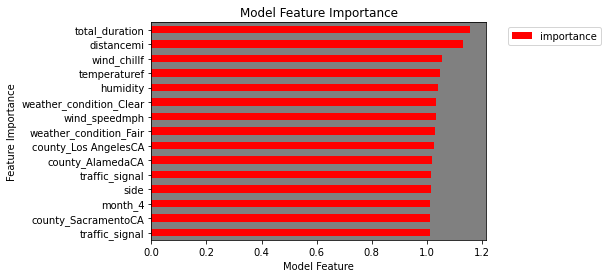

In [104]:
ax = i_features_rf.sort_values(by = 'importance', ascending = False).head(15).plot(
    kind = 'barh',
    color = ['red']
)

positions = range(15)
labels = ('total_duration','distancemi','wind_chillf','temperaturef',
          'humidity','weather_condition_Clear','wind_speedmph',
          'weather_condition_Fair','county_Los AngelesCA','county_AlamedaCA',
          'traffic_signal','side','month_4','county_SacramentoCA','traffic_signal')

ax.set_facecolor('grey')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.yticks(positions,labels)
plt.xlabel('Model Feature')
plt.ylabel('Feature Importance')
plt.title('Model Feature Importance')
plt.gca().invert_yaxis();

### RandomForest Pipeline

In [32]:
# set up Pipeline
rf_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('rf', RandomForestClassifier())
])

In [33]:
# set parameters
rf_pipe_params = {
    'rf__n_estimators': [1,10,100],
    'rf__max_depth': [2,3],
    'rf__min_samples_split' : [5,10],
    'rf__min_samples_leaf' : [2,3],
}

In [34]:
# set up GridSearch
gs_rf = GridSearchCV(
    estimator = rf_pipe,
    param_grid = rf_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = -1
)

In [35]:
# fit GridSearch
gs_rf.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [2, 3],
                         'rf__min_samples_leaf': [2, 3],
                         'rf__min_samples_split': [5, 10],
                         'rf__n_estimators': [1, 10, 100]},
             verbose=1)

In [36]:
# look at best parameters
gs_rf.best_params_

{'rf__max_depth': 3,
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 10,
 'rf__n_estimators': 100}

In [37]:
# look at best scores
gs_rf.best_score_

0.7928494087530462

In [38]:
gs_rf.score(X_train,y_train)

0.7838086790393013

In [39]:
gs_rf.score(X_test,y_test)

0.7795100982532751

In [40]:
# turn results into a dataframe
gs_rf_results = pd.DataFrame(gs_rf.cv_results_)

In [41]:
# look at GridSearch results
gs_rf_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,17.397397,0.389453,1.097857,0.205143,2,2,5,1,"{'rf__max_depth': 2, 'rf__min_samples_leaf': 2...",0.516830,0.520328,0.277876,0.259169,0.286860,0.372212,0.119846,19
1,18.700860,0.232108,0.950472,0.048333,2,2,5,10,"{'rf__max_depth': 2, 'rf__min_samples_leaf': 2...",0.508983,0.504918,0.666799,0.690510,0.629215,0.600085,0.078527,15
2,25.596675,0.783582,1.395154,0.113940,2,2,5,100,"{'rf__max_depth': 2, 'rf__min_samples_leaf': 2...",0.746304,0.767954,0.788025,0.759823,0.746574,0.761736,0.015501,8
3,18.023959,0.193477,0.896733,0.038963,2,2,10,1,"{'rf__max_depth': 2, 'rf__min_samples_leaf': 2...",0.251876,0.324785,0.299824,0.296810,0.272588,0.289177,0.024924,24
4,18.127862,1.151192,0.992229,0.151363,2,2,10,10,"{'rf__max_depth': 2, 'rf__min_samples_leaf': 2...",0.487037,0.689316,0.502644,0.608404,0.503497,0.558179,0.078556,16
5,22.500966,1.013464,1.259231,0.085368,2,2,10,100,"{'rf__max_depth': 2, 'rf__min_samples_leaf': 2...",0.787071,0.774947,0.768408,0.762154,0.770114,0.772539,0.008340,6
6,15.699084,0.390700,1.007017,0.115454,2,3,5,1,"{'rf__max_depth': 2, 'rf__min_samples_leaf': 3...",0.275188,0.368795,0.289759,0.318019,0.305225,0.311397,0.032112,22
7,16.371865,0.990634,1.236105,0.179934,2,3,5,10,"{'rf__max_depth': 2, 'rf__min_samples_leaf': 3...",0.630942,0.524023,0.698186,0.652925,0.655712,0.632358,0.058378,13
8,24.032172,0.757328,1.535975,0.168360,2,3,5,100,"{'rf__max_depth': 2, 'rf__min_samples_leaf': 3...",0.767171,0.798886,0.771650,0.799625,0.794792,0.786424,0.014061,3
9,13.864327,1.004786,1.191003,0.142488,2,3,10,1,"{'rf__max_depth': 2, 'rf__min_samples_leaf': 3...",0.328463,0.274464,0.315403,0.271223,0.286518,0.295214,0.022781,23


In [42]:
# create a dataframe of important features
i_features_gs_rf = pd.DataFrame(np.exp(gs_rf.best_estimator_[1].feature_importances_))

In [43]:
# add a column that shows the important features
i_features_gs_rf['features'] = X_train.columns

In [44]:
# sort important features (looked at both ascending = True and False)
i_features_gs_rf.sort_values(by = 0, ascending = False).head()

,0,features
1970,1.085222,weather_condition_Fair
17,1.064290,total_duration
5,1.061966,traffic_signal
1094,1.049566,county_Los AngelesCA
12,1.038650,traffic_signal.1


<a id='logr'></a>
### LogisticRegression

In [45]:
# instantiate LogisticRegression
logr = LogisticRegression()

In [46]:
# fit model
logr.fit(X_train_sc,y_train)

/home/jaco_lau55/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [47]:
# score train data
logr.score(X_train_sc,y_train)

0.8677333515283843

In [48]:
# score test data
logr.score(X_test_sc,y_test)

0.861217248908297

In [49]:
# create a dataframe of important features
coefs_logr = pd.DataFrame(np.exp(logr.coef_[0]))

In [50]:
# make feature column
coefs_logr['feature'] = X_train.columns

In [51]:
# sort important coefficients (looked at both ascending = True and False)
coefs_logr.sort_values(by = 0, ascending = False).head()

,0,feature
11,385.593693,wind_chillf
10,5.390492,distancemi
3,3.027979,wind_speedmph
1144,2.138372,county_MaricopaAZ
45,1.849081,month_4


## LogisticRegression Pipeline

In [52]:
# set up Pipeline
logr_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('logr', LogisticRegression())
])

In [53]:
# set parameters
logr_pipe_params = {
    'logr__penalty': ['l1','l2'],
    'logr__C': [15,20,25],
}

In [54]:
# set up GridSearch
gs_logr = GridSearchCV(
    estimator = logr_pipe,
    param_grid = logr_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = -1
)

In [55]:
# fit GridSearch
gs_logr.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  30 | elapsed:   17.1s remaining:   19.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.4min finished
/home/jaco_lau55/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('logr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logr__C': [15, 20, 25],
                         'logr__penalty': ['l1', 'l2']},
             verbose=1)

In [56]:
# look at best parameters
gs_logr.best_params_

{'logr__C': 25, 'logr__penalty': 'l2'}

In [57]:
# look at best scores
gs_logr.best_score_

0.862263453662554

In [58]:
gs_logr.score(X_test,y_test)

0.8611149017467249

In [59]:
# turn results into a dataframe
gs_logr_results = pd.DataFrame(gs_logr.cv_results_)

In [60]:
# look at GridSearch results
gs_logr_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logr__C,param_logr__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,15.929002,0.592332,0.000000,0.000000,15,l1,"{'logr__C': 15, 'logr__penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
1,121.984190,11.630135,0.556377,0.055786,15,l2,"{'logr__C': 15, 'logr__penalty': 'l2'}",0.862804,0.862740,0.857565,0.865128,0.862455,0.862138,0.002480,3
2,16.661320,0.195264,0.000000,0.000000,20,l1,"{'logr__C': 20, 'logr__penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,126.916747,13.047984,0.535743,0.063223,20,l2,"{'logr__C': 20, 'logr__penalty': 'l2'}",0.862975,0.861659,0.858077,0.865867,0.862455,0.862207,0.002506,2
4,15.127756,2.440170,0.000000,0.000000,25,l1,"{'logr__C': 25, 'logr__penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
5,103.802192,10.725682,0.547664,0.052775,25,l2,"{'logr__C': 25, 'logr__penalty': 'l2'}",0.863202,0.862455,0.857679,0.865469,0.862512,0.862263,0.002541,1


In [61]:
# create a dataframe of coefficients
coefs_gs_logr = pd.DataFrame(np.exp(gs_logr.best_estimator_[1].coef_[0]))

In [62]:
# add a column that shows the coeficient
coefs_gs_logr['features'] = X_train.columns

In [63]:
# sort coefficients (looked at both ascending = True and False)
coefs_gs_logr.sort_values(by = 0, ascending = False).head()

,0,features
11,997.777023,wind_chillf
10,8.618996,distancemi
3,3.672203,wind_speedmph
1144,2.536605,county_MaricopaAZ
1425,2.108225,county_PimaAZ


<a id='dt'></a>
## DecisionTree

In [64]:
# instantiate DecisionTreeClassifier
dt = DecisionTreeClassifier()

In [65]:
# fit model
dt.fit(X_train_sc,y_train)

DecisionTreeClassifier()

In [66]:
# score train data
dt.score(X_train_sc,y_train)

0.9966339155749636

In [67]:
# score test data
dt.score(X_test_sc,y_test)

0.8583856441048034

In [68]:
# create a dataframe of important features
i_features_dt = pd.DataFrame(list(zip(dt.feature_importances_,X_train.columns)),columns = ['importance','feature'])

In [69]:
# sort important features (looked at both ascending = True and False)
i_features_dt.sort_values(by = 'importance', ascending = False).head()

,importance,feature
10,0.324090,distancemi
17,0.138737,total_duration
1970,0.110254,weather_condition_Fair
11,0.037569,wind_chillf
1094,0.033459,county_Los AngelesCA


### DecisionTree Pipeline

In [70]:
# set up Pipeline
dt_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('dt', DecisionTreeClassifier())
])

In [71]:
# set parameters
dt_pipe_params = {
    'dt__max_depth': [2,3],
    'dt__min_samples_split' : [5,10],
    'dt__min_samples_leaf' : [2,3],
}

In [72]:
# set up GridSearch
gs_dt = GridSearchCV(
    estimator = dt_pipe,
    param_grid = dt_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = -1
)

In [73]:
# fit GridSearch
gs_dt.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:   37.9s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   38.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('dt', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'dt__max_depth': [2, 3],
                         'dt__min_samples_leaf': [2, 3],
                         'dt__min_samples_split': [5, 10]},
             verbose=1)

In [74]:
# look at best parameters
gs_dt.best_params_

{'dt__max_depth': 3, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 5}

In [75]:
# look at best scores
gs_dt.best_score_

0.6429562275275718

In [76]:
# score test data
gs_dt.score(X_test,y_test)

0.6350982532751092

In [77]:
# score train data
gs_dt.score(X_train,y_train)

0.6430585880640466

In [78]:
# turn results into a dataframe
gs_dt_results = pd.DataFrame(gs_dt.cv_results_)

In [79]:
# look at GridSearch results
gs_dt_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__max_depth,param_dt__min_samples_leaf,param_dt__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,20.383538,0.325441,0.952079,0.171114,2,2,5,"{'dt__max_depth': 2, 'dt__min_samples_leaf': 2...",0.595065,0.597657,0.596179,0.598795,0.591858,0.595911,0.002391,5
1,20.732410,0.194327,1.078362,0.122106,2,2,10,"{'dt__max_depth': 2, 'dt__min_samples_leaf': 2...",0.595065,0.597657,0.596179,0.598795,0.591858,0.595911,0.002391,5
2,20.739899,0.256849,1.077341,0.086316,2,3,5,"{'dt__max_depth': 2, 'dt__min_samples_leaf': 3...",0.595065,0.597657,0.596179,0.598795,0.591858,0.595911,0.002391,5
3,20.743439,0.199095,1.028634,0.087549,2,3,10,"{'dt__max_depth': 2, 'dt__min_samples_leaf': 3...",0.595065,0.597657,0.596179,0.598795,0.591858,0.595911,0.002391,5
4,20.387929,4.112097,1.093520,0.362928,3,2,5,"{'dt__max_depth': 3, 'dt__min_samples_leaf': 2...",0.644132,0.643430,0.643089,0.644908,0.639222,0.642956,0.001969,1
5,13.882627,1.697322,0.627068,0.110148,3,2,10,"{'dt__max_depth': 3, 'dt__min_samples_leaf': 2...",0.644132,0.643430,0.643089,0.644908,0.639222,0.642956,0.001969,1
6,13.562167,1.563547,0.632989,0.113303,3,3,5,"{'dt__max_depth': 3, 'dt__min_samples_leaf': 3...",0.644132,0.643430,0.643089,0.644908,0.639222,0.642956,0.001969,1
7,14.799542,1.570814,0.513401,0.094683,3,3,10,"{'dt__max_depth': 3, 'dt__min_samples_leaf': 3...",0.644132,0.643430,0.643089,0.644908,0.639222,0.642956,0.001969,1


In [80]:
# create a dataframe of important features
i_features_gs_dt = pd.DataFrame(np.exp(gs_dt.best_estimator_[1].feature_importances_))

In [81]:
# add a column that shows the important features
i_features_gs_dt['features'] = X_train.columns

In [82]:
# sort important features (looked at both ascending = True and False)
i_features_gs_dt.sort_values(by = 0, ascending = False).head()

,0,features
10,1.801831,distancemi
1970,1.263390,weather_condition_Fair
17,1.194106,total_duration
1354,1.000000,county_OrangeFL
1355,1.000000,county_OrangeNC


<a id='mr'></a>
## Model Results

In [83]:
# create a df of train and test scores for each model 
scores = [
{ # RandomForest scores
    'train score': rf.score(X_train_sc,y_train),
    'test score': rf.score(X_test_sc,y_test)
},
{ # RandomForest GridSearch scores
    'train score': gs_rf.score(X_train,y_train),
    'test score': gs_rf.score(X_test,y_test)
},
{ # LogisticRegression scores
    'train score': logr.score(X_train_sc,y_train),
    'test score': logr.score(X_test_sc,y_test)
},
{ # LogisticRegression GridSearch scores
    'train score': gs_logr.score(X_train,y_train),
    'test score': gs_logr.score(X_test,y_test)
},
{ # DecisionTree scores
    'train score': dt.score(X_train_sc,y_train),
    'test score': dt.score(X_test_sc,y_test)
},
{ # DecisionTree GridSearch scores
    'train score': gs_dt.score(X_train,y_train),
    'test score': gs_dt.score(X_test,y_test)
}
    ]

In [84]:
scores

[{'train score': 0.9966339155749636, 'test score': 0.8764669759825328},
 {'train score': 0.7838086790393013, 'test score': 0.7795100982532751},
 {'train score': 0.8677333515283843, 'test score': 0.861217248908297},
 {'train score': 0.8680745087336245, 'test score': 0.8611149017467249},
 {'train score': 0.9966339155749636, 'test score': 0.8583856441048034},
 {'train score': 0.6430585880640466, 'test score': 0.6350982532751092}]

In [85]:
tests = ['RandomForest','RandomForest Pipe',
        'LogisticRegression','LogisticRegression Pipe',
        'DecisionTree','DecisionTree Pipe']

In [86]:
scores = pd.DataFrame(scores, index = tests)

In [87]:
nn = pd.read_csv('./data/severity_model_data/nn_results.csv',index_col = 0)

In [88]:
nn

,train score,test score
Neural Network,0.904214,0.881004


In [89]:
scores = pd.concat([scores,nn])

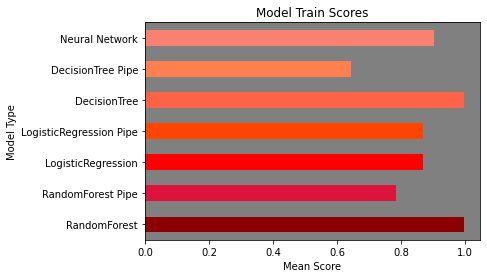

In [106]:
ax = scores.max(axis = 1).plot(
    kind = 'barh',
    color = ['darkred','crimson','red','orangered','tomato','coral','salmon']
)
positions = (0,1,2,3,4,5,6)
labels = ('RandomForest','RandomForest Pipe',
        'LogisticRegression','LogisticRegression Pipe',
        'DecisionTree','DecisionTree Pipe','Neural Network')

ax.set_facecolor('grey')
plt.yticks(positions,labels)
plt.xlabel('Mean Score')
plt.ylabel('Model Type')
plt.title('Model Train Scores');

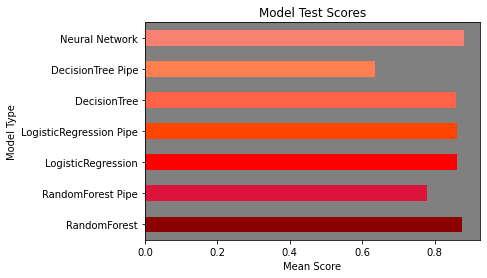

In [105]:
ax = scores.min(axis = 1).plot(
    kind = 'barh',
        color = ['darkred','crimson','red','orangered','tomato','coral','salmon']

)
positions = (0,1,2,3,4,5,6)
labels = ('RandomForest','RandomForest Pipe',
        'LogisticRegression','LogisticRegression Pipe',
        'DecisionTree','DecisionTree Pipe','Neural Network')

ax.set_facecolor('grey')
plt.yticks(positions,labels)
plt.xlabel('Mean Score')
plt.ylabel('Model Type')
plt.title('Model Test Scores');